### N-BEATS Model Experiment for Walmart Sales Forecasting

This notebook implements and experiments with N-BEATS (Neural Basis Expansion Analysis for Time Series) for time series forecasting on Walmart sales data.

### CELL 1: Setup and Installations
Install required packages

In [1]:
!pip install darts
!pip install pytorch-lightning
!pip install mlflow
!pip install dagshub
!pip install joblib
!pip install scikit-learn
!pip install pandas numpy matplotlib seaborn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### CELL 2: Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ML-Final')

Mounted at /content/drive


### CELL 3: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PyTorch and Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Darts for N-BEATS
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, mape, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.model_selection import train_test_split

# Sklearn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# MLflow and experiment tracking
import mlflow
import mlflow.pytorch
import dagshub

# System utilities
import sys
sys.path.append('.')

### CELL 4: Initialize MLflow and Load Data
Initialize MLflow experiment tracking

In [4]:
dagshub.init(repo_owner='egval20', repo_name='ML-Final', mlflow=True)
mlflow.set_experiment("N-BEATS")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ccadc2b6-a8ae-43ce-bb7d-98aa9ad66596&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=069ce76fca0d0b821b203a11ef9161442f97182761456e750071ee46421cc2b6




Accessing as lagorg22

Initialized MLflow to track repo "egval20/ML-Final"

Repository egval20/ML-Final initialized!

<Experiment: artifact_location='mlflow-artifacts:/13d77dc0495f4224b3223b8bf14db409', creation_time=1751814607514, experiment_id='7', last_update_time=1751814607514, lifecycle_stage='active', name='N-BEATS', tags={}>

### CELL 5: Load Preprocessing Pipeline and Data

In [5]:
from data_preprocessing_pipeline import *

def get_model_ready_data(pipeline_path='preprocessing_pipeline.pkl'):
    pipeline = joblib.load(pipeline_path)
    def preprocess_for_model(raw_data):
        return pipeline.transform(raw_data)
    return preprocess_for_model, pipeline

# Load preprocessing pipeline
preprocess_fn, loaded_pipeline = get_model_ready_data()

# Load raw data
print("Loading raw data...")
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"Date range - Train: {train_raw['Date'].min()} to {train_raw['Date'].max()}")
print(f"Date range - Test: {test_raw['Date'].min()} to {test_raw['Date'].max()}")

Loading raw data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Date range - Train: 2010-02-05 to 2012-10-26
Date range - Test: 2012-11-02 to 2013-07-26


### CELL 6: Apply Preprocessing

In [6]:
train_processed = preprocess_fn(train_raw)
test_processed = preprocess_fn(test_raw)

# Drop lag features as suggested in ARIMA notebook
lag_columns_to_drop = [
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_52',
    'Sales_MA_4', 'Sales_MA_8', 'Sales_MA_12',
    'Sales_STD_4', 'Sales_STD_8', 'Sales_STD_12'
]

def drop_lag_features(data, columns_to_drop):
    existing_cols = [col for col in columns_to_drop if col in data.columns]
    cleaned_data = data.drop(columns=existing_cols)
    print(f"Dropped {len(existing_cols)} lag/MA columns")
    return cleaned_data

train_processed_clean = drop_lag_features(train_processed, lag_columns_to_drop)
test_processed_clean = drop_lag_features(test_processed, lag_columns_to_drop)

print(f"Cleaned train shape: {train_processed_clean.shape}")
print(f"Cleaned test shape: {test_processed_clean.shape}")

Dropped 12 lag/MA columns
Dropped 12 lag/MA columns
Cleaned train shape: (421570, 52)
Cleaned test shape: (115064, 51)


### CELL 7: Prepare Time Series Data for N-BEATS

In [7]:
class NBEATSDataPreparation:
    def __init__(self):
        self.scalers = {}
        self.series_dict = {}

    def prepare_hierarchical_series(self, data, level='total'):
        """Prepare time series at different hierarchical levels"""
        data = data.copy()
        data['Date'] = pd.to_datetime(data['Date'])

        if level == 'total':
            # Total sales across all stores and departments
            series_df = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
            series_df = series_df.sort_values('Date')
            # Resample to ensure a complete weekly index
            series_df = series_df.set_index('Date').resample('W').sum().reset_index()
            return series_df

        elif level == 'store':
            # Sales by store
            series_dict = {}
            for store in data['Store'].unique():
                store_data = data[data['Store'] == store]
                store_series = store_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
                store_series = store_series.sort_values('Date')
                # Resample to ensure a complete weekly index for each store
                store_series = store_series.set_index('Date').resample('W').sum().reset_index()
                series_dict[f'Store_{store}'] = store_series
            return series_dict

        elif level == 'store_dept':
            # Sales by store and department
            series_dict = {}
            for store in data['Store'].unique():
                for dept in data[data['Store'] == store]['Dept'].unique():
                    subset = data[(data['Store'] == store) & (data['Dept'] == dept)]
                    if len(subset) > 20:  # Only include series with sufficient data
                        series = subset.groupby('Date')['Weekly_Sales'].sum().reset_index()
                        series = series.sort_values('Date')
                        # Resample to ensure a complete weekly index for each store/dept
                        series = series.set_index('Date').resample('W').sum().reset_index()
                        series_dict[f'Store_{store}_Dept_{dept}'] = series
            return series_dict

    def create_darts_timeseries(self, series_df, freq='W'):
        """Convert pandas DataFrame to Darts TimeSeries"""
        return TimeSeries.from_dataframe(
            series_df,
            time_col='Date',
            value_cols='Weekly_Sales',
            freq=freq,
            # fill_missing_dates=fill_missing_dates # Not needed after resampling
        )

# Initialize data preparation
data_prep = NBEATSDataPreparation()

### CELL 8: Create Time Series at Different Levels

Creating hierarchical time series...
Total sales series length: 143
Date range: 2010-02-07 00:00:00 to 2012-10-28 00:00:00


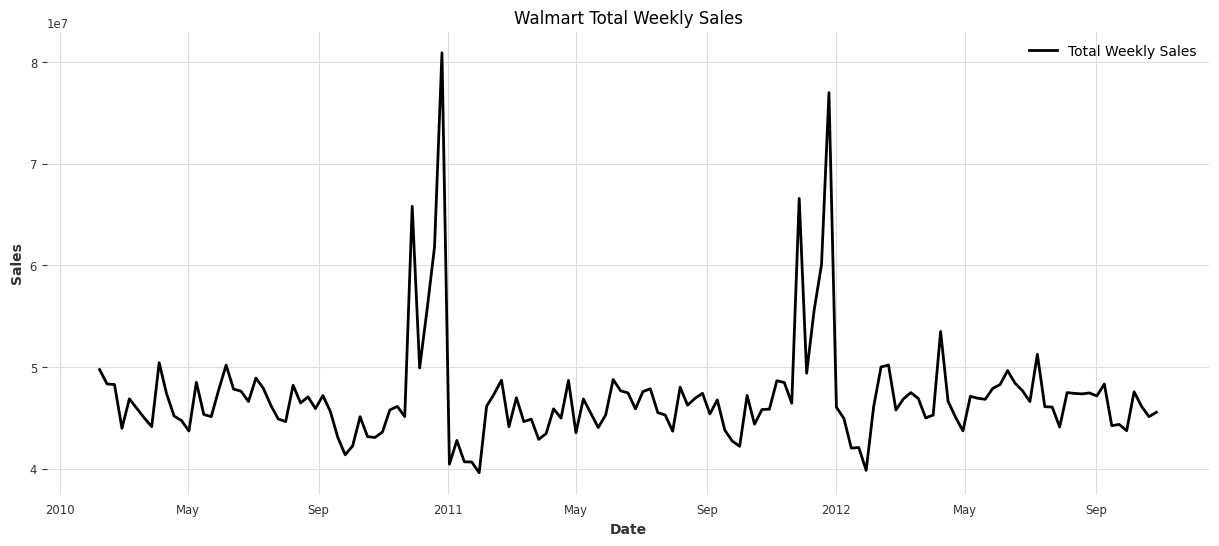

In [8]:
print("Creating hierarchical time series...")

# Total sales
total_sales_df = data_prep.prepare_hierarchical_series(train_processed_clean, level='total')
total_sales_ts = data_prep.create_darts_timeseries(total_sales_df)

print(f"Total sales series length: {len(total_sales_ts)}")
print(f"Date range: {total_sales_ts.start_time()} to {total_sales_ts.end_time()}")

# Visualize total sales
plt.figure(figsize=(15, 6))
total_sales_ts.plot(label='Total Weekly Sales')
plt.title('Walmart Total Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### CELL 9: Train-Validation Split

In [9]:
# Split the series to ensure validation set has enough points (at least input_chunk_length + output_chunk_length)
# The largest required length among the ensemble models is 32 (input) + 8 (output) = 40
min_required_val_length = 40
# Increase target validation length slightly to avoid sampling issues
target_val_length = min_required_val_length + 1
total_length = len(total_sales_ts)
train_length = total_length - target_val_length

# Ensure train length is not negative and target_val_length is achievable
if train_length < 0:
    raise ValueError(f"Total series length ({total_length}) is not enough for the target validation length ({target_val_length}).")

train_ts, val_ts = total_sales_ts.split_after(train_length)

print(f"Training series: {train_ts.start_time()} to {train_ts.end_time()} (length: {len(train_ts)})")
print(f"Validation series: {val_ts.start_time()} to {val_ts.end_time()} (length: {len(val_ts)})")

# Scale the data
scaler = Scaler()
train_ts_scaled = scaler.fit_transform(train_ts)
val_ts_scaled = scaler.transform(val_ts)
total_ts_scaled = scaler.transform(total_sales_ts)

Training series: 2010-02-07 00:00:00 to 2012-01-22 00:00:00 (length: 103)
Validation series: 2012-01-29 00:00:00 to 2012-10-28 00:00:00 (length: 40)


### CELL 10: N-BEATS Model Configuration

In [ ]:
# Start MLflow run for N-BEATS cleaning
with mlflow.start_run(run_name="N-BEATS_Cleaning"):
    mlflow.log_param("columns_to_drop_count", len(lag_columns_to_drop))
    mlflow.log_param("columns_to_drop", lag_columns_to_drop)
    mlflow.log_metric("original_train_rows", train_processed.shape[0])
    mlflow.log_metric("original_train_cols", train_processed.shape[1])
    mlflow.log_metric("final_train_rows", train_processed_clean.shape[0])
    mlflow.log_metric("final_train_cols", train_processed_clean.shape[1])

🏃 View run N-BEATS_Cleaning at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/26cb78ab18c94ccca8a076ffa5b49cc4
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


### CELL 11: Train Baseline N-BEATS Model

=== Training Baseline N-BEATS Model ===
Training baseline model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.785    Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Baseline Model Performance:
MAE: 2054035.02
RMSE: 2650427.09
MAPE: 4.32%


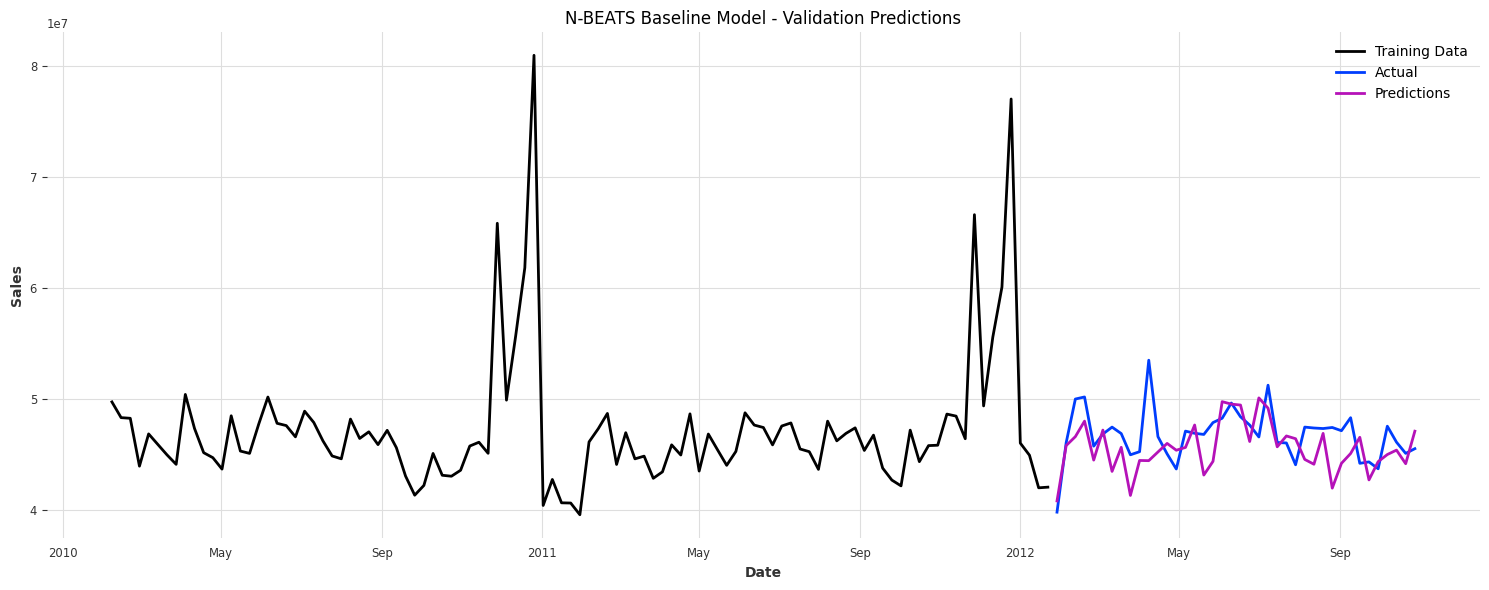

🏃 View run N-BEATS_Baseline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/a74cb268792f4ea9a0b964d416f82b1b
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


In [10]:
with mlflow.start_run(run_name="N-BEATS_Baseline"):
    print("=== Training Baseline N-BEATS Model ===")

    # Model parameters
    input_chunk_length = 24  # Look back 24 weeks
    output_chunk_length = 8  # Predict 8 weeks ahead

    # Log parameters
    mlflow.log_param("model_type", "N-BEATS_Generic")
    mlflow.log_param("input_chunk_length", input_chunk_length)
    mlflow.log_param("output_chunk_length", output_chunk_length)
    mlflow.log_param("num_stacks", 30)
    mlflow.log_param("num_blocks", 1)
    mlflow.log_param("num_layers", 4)
    mlflow.log_param("layer_widths", 256)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("n_epochs", 100)
    mlflow.log_param("learning_rate", 1e-3) # Keep this for logging

    # Create N-BEATS model
    model_baseline = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        generic_architecture=True,
        num_stacks=30,
        num_blocks=1,
        num_layers=4,
        layer_widths=256,
        n_epochs=100,
        batch_size=32,
        model_name="nbeats_baseline",
        log_tensorboard=False,
        random_state=42,
        force_reset=True,
        save_checkpoints=True,
        optimizer_kwargs={"lr": 1e-3}, # Pass learning rate here
        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        }
    )

    # Train the model
    print("Training baseline model...")
    model_baseline.fit(
        series=train_ts_scaled,
        val_series=val_ts_scaled,
        verbose=True
    )

    # Make predictions on validation set
    n_pred = len(val_ts_scaled)
    predictions = model_baseline.predict(n=n_pred, series=train_ts_scaled)

    # Inverse transform predictions
    predictions_unscaled = scaler.inverse_transform(predictions)

    # Calculate metrics
    mae_score = mae(val_ts, predictions_unscaled)
    rmse_score = rmse(val_ts, predictions_unscaled)
    mape_score = mape(val_ts, predictions_unscaled)

    print(f"\nBaseline Model Performance:")
    print(f"MAE: {mae_score:.2f}")
    print(f"RMSE: {rmse_score:.2f}")
    print(f"MAPE: {mape_score:.2f}%")

    # Log metrics
    mlflow.log_metric("val_mae", mae_score)
    mlflow.log_metric("val_rmse", rmse_score)
    mlflow.log_metric("val_mape", mape_score)

    # Plot predictions
    plt.figure(figsize=(15, 6))
    train_ts.plot(label='Training Data')
    val_ts.plot(label='Actual')
    predictions_unscaled.plot(label='Predictions')
    plt.title('N-BEATS Baseline Model - Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.savefig('nbeats_baseline_predictions.png')
    plt.show()

    # Log artifacts
    mlflow.log_artifact('nbeats_baseline_predictions.png')

    # Save model
    model_baseline.save("nbeats_baseline_model.pkl")
    mlflow.log_artifact("nbeats_baseline_model.pkl")

### CELL 12: Train Interpretable N-BEATS Model
Train interpretable N-BEATS model (with trend and seasonality stacks)


=== Training Interpretable N-BEATS Model ===


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 417 K  | train
-------------------------------------------------------------
410 K     Trainable params
6.6 K     Non-trainable params
417 K     Total params
1.670     Total estimated m

Training interpretable model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Interpretable Model Performance:
MAE: 2134617.05
RMSE: 2689893.12
MAPE: 4.47%


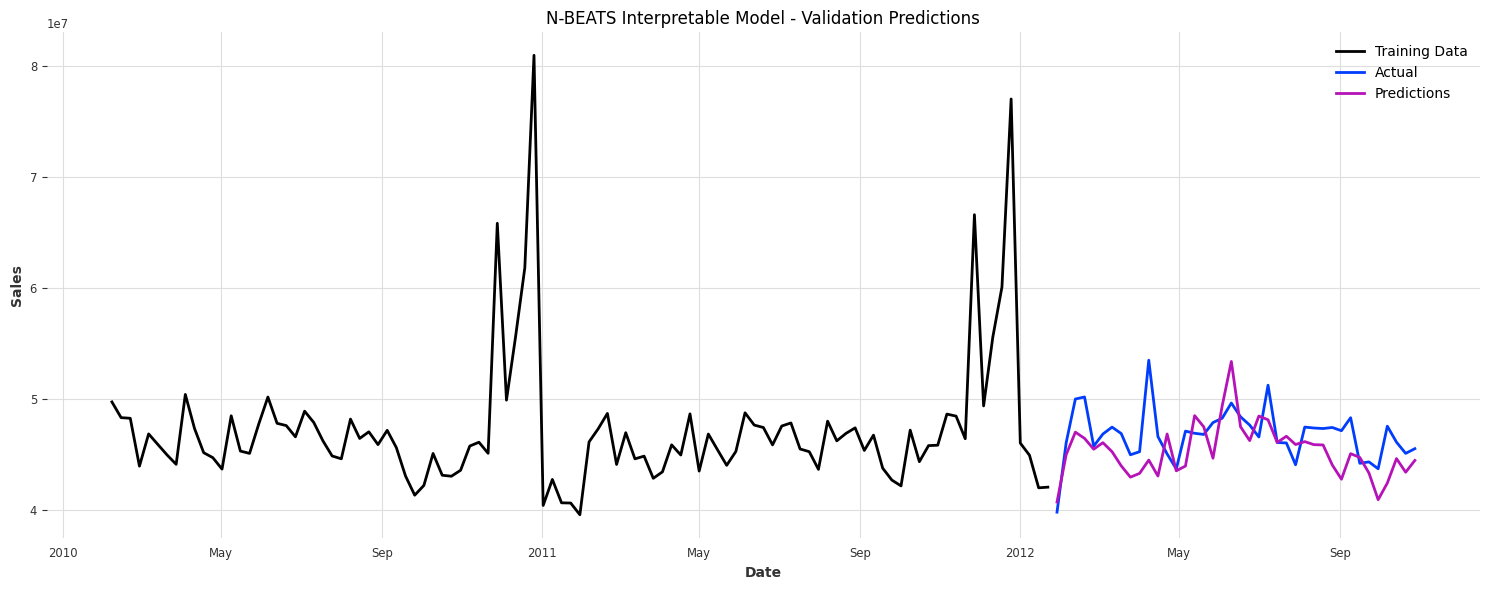

🏃 View run N-BEATS_Interpretable at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/97b62a2b6ad140a6a609aaee5a647493
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


In [11]:
with mlflow.start_run(run_name="N-BEATS_Interpretable"):
    print("\n=== Training Interpretable N-BEATS Model ===")

    # Log parameters
    mlflow.log_param("model_type", "N-BEATS_Interpretable")
    mlflow.log_param("input_chunk_length", input_chunk_length)
    mlflow.log_param("output_chunk_length", output_chunk_length)
    mlflow.log_param("num_stacks", 2)
    mlflow.log_param("trend_polynomial_degree", 2)
    mlflow.log_param("num_blocks", 3)
    mlflow.log_param("num_layers", 4)
    mlflow.log_param("layer_widths", 256)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("n_epochs", 100)
    mlflow.log_param("learning_rate", 1e-3) # Keep this for logging

    # Create interpretable N-BEATS model
    model_interpretable = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        generic_architecture=False,  # Use interpretable architecture
        num_stacks=2,  # Trend and seasonality stacks
        num_blocks=3,
        num_layers=4,
        layer_widths=256,
        expansion_coefficient_dim=5,
        trend_polynomial_degree=2,
        n_epochs=100,
        batch_size=32,
        optimizer_kwargs={"lr": 1e-3}, # Pass learning rate here
        model_name="nbeats_interpretable",
        log_tensorboard=False,
        random_state=42,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        }
    )

    # Train the model
    print("Training interpretable model...")
    model_interpretable.fit(
        series=train_ts_scaled,
        val_series=val_ts_scaled,
        verbose=True
    )

    # Make predictions
    predictions_interp = model_interpretable.predict(n=n_pred, series=train_ts_scaled)
    predictions_interp_unscaled = scaler.inverse_transform(predictions_interp)

    # Calculate metrics
    mae_score_interp = mae(val_ts, predictions_interp_unscaled)
    rmse_score_interp = rmse(val_ts, predictions_interp_unscaled)
    mape_score_interp = mape(val_ts, predictions_interp_unscaled)

    print(f"\nInterpretable Model Performance:")
    print(f"MAE: {mae_score_interp:.2f}")
    print(f"RMSE: {rmse_score_interp:.2f}")
    print(f"MAPE: {mape_score_interp:.2f}%")

    # Log metrics
    mlflow.log_metric("val_mae", mae_score_interp)
    mlflow.log_metric("val_rmse", rmse_score_interp)
    mlflow.log_metric("val_mape", mape_score_interp)

    # Plot predictions
    plt.figure(figsize=(15, 6))
    train_ts.plot(label='Training Data')
    val_ts.plot(label='Actual')
    predictions_interp_unscaled.plot(label='Predictions')
    plt.title('N-BEATS Interpretable Model - Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.savefig('nbeats_interpretable_predictions.png')
    plt.show()

    # Log artifacts
    mlflow.log_artifact('nbeats_interpretable_predictions.png')

    # Save model
    model_interpretable.save("nbeats_interpretable_model.pkl")
    mlflow.log_artifact("nbeats_interpretable_model.pkl")

### CELL 13: Hyperparameter Tuning

In [12]:
with mlflow.start_run(run_name="N-BEATS_Hyperparameter_Search"):
    print("\n=== N-BEATS Hyperparameter Search ===")

    # Define hyperparameter search space
    param_grid = {
        'input_chunk_length': [16, 24, 32],
        'num_stacks': [20, 30],
        'num_layers': [3, 4],
        'layer_widths': [128, 256],
        'learning_rate': [1e-3, 5e-4]
    }

    best_mae = float('inf')
    best_params = {}

    # Simplified grid search (testing only a subset for demo)
    for input_len in [24]:
        for num_stacks in [20]:
            for lr in [1e-3, 5e-4]:
                print(f"\nTesting: input_length={input_len}, stacks={num_stacks}, lr={lr}")

                try:
                    model_search = NBEATSModel(
                        input_chunk_length=input_len,
                        output_chunk_length=8,
                        generic_architecture=True,
                        num_stacks=num_stacks,
                        num_blocks=1,
                        num_layers=4,
                        layer_widths=256,
                        n_epochs=50,  # Fewer epochs for search
                        batch_size=32,
                        optimizer_kwargs={"lr": lr}, # Pass learning rate here
                        model_name=f"nbeats_search_{input_len}_{num_stacks}_{lr}",
                        log_tensorboard=False,
                        random_state=42,
                        force_reset=True,
                        pl_trainer_kwargs={
                            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
                        }
                    )

                    # Train model
                    model_search.fit(
                        series=train_ts_scaled,
                        val_series=val_ts_scaled,
                        verbose=False
                    )

                    # Evaluate
                    pred_search = model_search.predict(n=len(val_ts_scaled), series=train_ts_scaled)
                    pred_search_unscaled = scaler.inverse_transform(pred_search)
                    mae_search = mae(val_ts, pred_search_unscaled)

                    print(f"MAE: {mae_search:.2f}")

                    # Track best model
                    if mae_search < best_mae:
                        best_mae = mae_search
                        best_params = {
                            'input_chunk_length': input_len,
                            'num_stacks': num_stacks,
                            'learning_rate': lr
                        }

                    # Log trial
                    mlflow.log_metric(f"mae_input{input_len}_stacks{num_stacks}_lr{lr}", mae_search)

                except Exception as e:
                    print(f"Error in trial: {e}")
                    continue

    print(f"\nBest parameters: {best_params}")
    print(f"Best MAE: {best_mae:.2f}")

    # Log best parameters
    for param, value in best_params.items():
        mlflow.log_param(f"best_{param}", value)
    mlflow.log_metric("best_mae", best_mae)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



=== N-BEATS Hyperparameter Search ===

Testing: input_length=24, stacks=20, lr=0.001


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 2255618.93


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: input_length=24, stacks=20, lr=0.0005


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 2152104.78

Best parameters: {'input_chunk_length': 24, 'num_stacks': 20, 'learning_rate': 0.0005}
Best MAE: 2152104.78
🏃 View run N-BEATS_Hyperparameter_Search at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/96ccbc5d3261420c8bebf7c9d6f92cd4
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


### CELL 14: Train Final Model on Full Data


=== Training Final N-BEATS Model ===
Using generic architecture for final model


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training final model on full dataset...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.785    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Generating 38 week forecast...


Predicting: |          | 0/? [00:00<?, ?it/s]

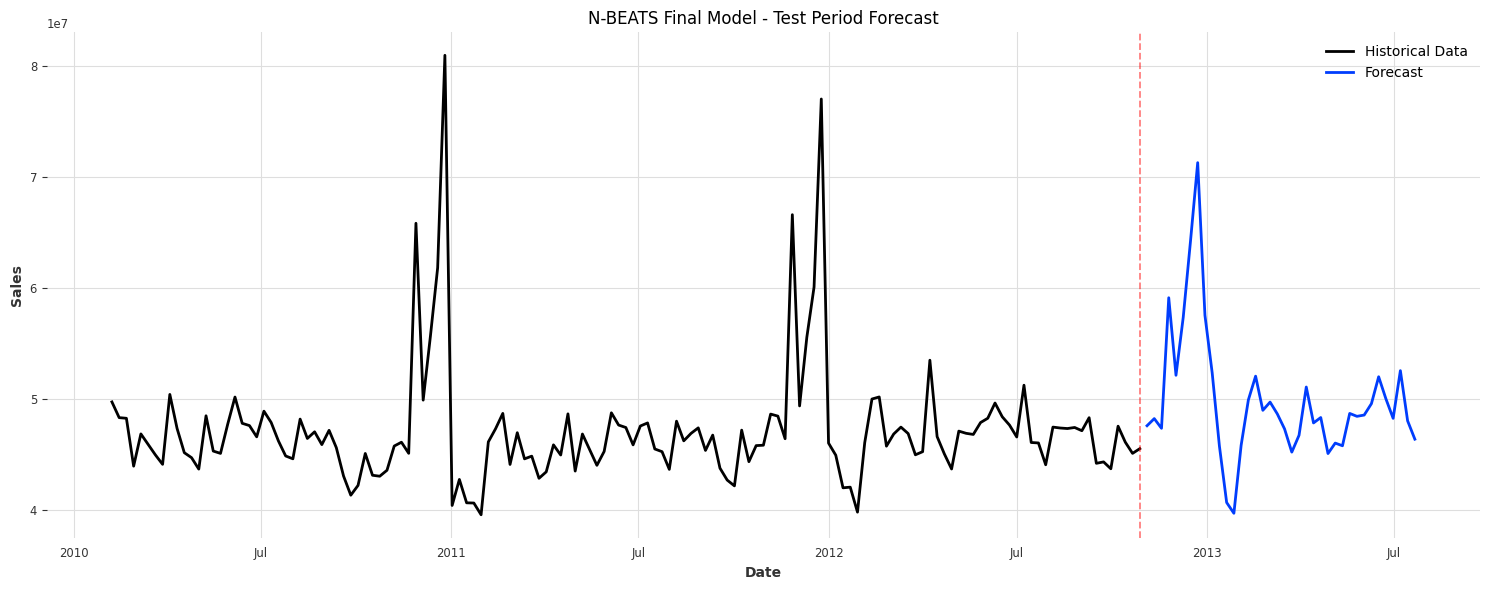

Final model training complete!
🏃 View run N-BEATS_Final_Model at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/d7cfd24ddaa44a76acfa55f778f1c1fc
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


In [13]:
with mlflow.start_run(run_name="N-BEATS_Final_Model"):
    print("\n=== Training Final N-BEATS Model ===")

    # Use best model (interpretable if better, else baseline)
    use_interpretable = mae_score_interp < mae_score

    if use_interpretable:
        print("Using interpretable architecture for final model")
        final_model = NBEATSModel(
            input_chunk_length=input_chunk_length,
            output_chunk_length=output_chunk_length,
            generic_architecture=False,
            num_stacks=2,
            num_blocks=3,
            num_layers=4,
            layer_widths=256,
            expansion_coefficient_dim=5,
            trend_polynomial_degree=2,
            n_epochs=150,
            batch_size=32,
            optimizer_kwargs={"lr": 1e-3}, # Pass learning rate here
            model_name="nbeats_final",
            log_tensorboard=False,
            random_state=42,
            force_reset=True,
            save_checkpoints=True,
            pl_trainer_kwargs={
                "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            }
        )
    else:
        print("Using generic architecture for final model")
        final_model = NBEATSModel(
            input_chunk_length=input_chunk_length,
            output_chunk_length=output_chunk_length,
            generic_architecture=True,
            num_stacks=30,
            num_blocks=1,
            num_layers=4,
            layer_widths=256,
            n_epochs=150,
            batch_size=32,
            optimizer_kwargs={"lr": 1e-3}, # Pass learning rate here
            model_name="nbeats_final",
            log_tensorboard=False,
            random_state=42,
            force_reset=True,
            save_checkpoints=True,
            pl_trainer_kwargs={
                "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            }
        )

    # Log final model configuration
    mlflow.log_param("final_model_type", "interpretable" if use_interpretable else "generic")
    mlflow.log_param("final_n_epochs", 150)

    # Train on full data
    print("Training final model on full dataset...")
    final_model.fit(
        series=total_ts_scaled,
        verbose=True
    )

    # Generate forecasts for test period
    test_start_date = pd.to_datetime(test_raw['Date'].min())
    test_end_date = pd.to_datetime(test_raw['Date'].max())
    n_test_periods = len(pd.date_range(start=test_start_date, end=test_end_date, freq='W'))

    print(f"\nGenerating {n_test_periods} week forecast...")
    forecast = final_model.predict(n=n_test_periods, series=total_ts_scaled)
    forecast_unscaled = scaler.inverse_transform(forecast)

    # Plot final results
    plt.figure(figsize=(15, 6))
    total_sales_ts.plot(label='Historical Data')
    forecast_unscaled.plot(label='Forecast')
    plt.axvline(x=total_sales_ts.end_time(), color='red', linestyle='--', alpha=0.5)
    plt.title('N-BEATS Final Model - Test Period Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.savefig('nbeats_final_forecast.png')
    plt.show()

    # Save final model and artifacts
    final_model.save("nbeats_final_model.pkl")
    mlflow.log_artifact("nbeats_final_model.pkl")
    mlflow.log_artifact('nbeats_final_forecast.png')

    # Save scaler
    joblib.dump(scaler, 'nbeats_scaler.pkl')
    mlflow.log_artifact('nbeats_scaler.pkl')

    print("Final model training complete!")

### CELL 15: Multi-Series N-BEATS (Store Level)

In [14]:
with mlflow.start_run(run_name="N-BEATS_Multi_Store"):
    print("\n=== Training N-BEATS for Top 5 Stores ===")

    # Get top 5 stores by total sales
    store_sales = train_processed_clean.groupby('Store')['Weekly_Sales'].sum().nlargest(5)
    top_stores = store_sales.index.tolist()

    print(f"Top 5 stores: {top_stores}")
    mlflow.log_param("top_stores", top_stores)

    store_models = {}
    store_metrics = {}

    # Prepare store-level series using the existing data preparation class
    store_series_dict_df = data_prep.prepare_hierarchical_series(train_processed_clean, level='store')

    for store in top_stores:
        store_key = f'Store_{store}'
        if store_key not in store_series_dict_df:
            print(f"Warning: Data for store {store} not found in prepared hierarchical series.")
            continue

        print(f"\nTraining model for Store {store}")

        # Get the DataFrame for the current store from the prepared data
        store_series_df = store_series_dict_df[store_key]

        # Create Darts TimeSeries (resampling is already done in prepare_hierarchical_series)
        store_ts = data_prep.create_darts_timeseries(store_series_df)

        # Split data (adjust split ratio if needed for store level)
        # Ensure train and validation sets are long enough for model input/output chunks
        # Using a fixed number of points for validation might be safer, similar to total sales
        # input_chunk_length=16, output_chunk_length=4 -> min required length = 20
        min_required_store_val_length = 16 + 4
        store_total_length = len(store_ts)

        if store_total_length < min_required_store_val_length:
            print(f"Warning: Not enough data for Store {store} ({store_total_length} points). Skipping.")
            continue

        # Aim for a validation set of at least 20 points
        store_val_length = max(min_required_store_val_length, int(store_total_length * 0.2)) # Use at least 20% or minimum required
        store_train_length = store_total_length - store_val_length

        if store_train_length <= 0:
             print(f"Warning: Training set length is 0 or negative for Store {store}. Skipping.")
             continue


        store_train_ts, store_val_ts = store_ts.split_after(store_train_length)

        print(f"Store {store} - Training series length: {len(store_train_ts)}, Validation series length: {len(store_val_ts)}")


        # Scale data
        store_scaler = Scaler()
        store_train_scaled = store_scaler.fit_transform(store_train_ts)
        store_val_scaled = store_scaler.transform(store_val_ts)

        # Create model for this store
        store_model = NBEATSModel(
            input_chunk_length=16,  # Shorter lookback for store-level
            output_chunk_length=4,
            generic_architecture=True,
            num_stacks=20,
            num_blocks=1,
            num_layers=3,
            layer_widths=128,
            n_epochs=50,
            batch_size=16,
            optimizer_kwargs={"lr": 1e-3}, # Pass learning rate here
            model_name=f"nbeats_store_{store}",
            log_tensorboard=False,
            random_state=42,
            force_reset=True,
            pl_trainer_kwargs={
                "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            }
        )

        # Train model
        store_model.fit(
            series=store_train_scaled,
            val_series=store_val_scaled,
            verbose=False
        )

        # Evaluate
        store_pred = store_model.predict(n=len(store_val_ts), series=store_train_scaled)
        store_pred_unscaled = store_scaler.inverse_transform(store_pred)

        store_mae = mae(store_val_ts, store_pred_unscaled)
        store_rmse = rmse(store_val_ts, store_pred_unscaled)

        print(f"Store {store} - MAE: {store_mae:.2f}, RMSE: {store_rmse:.2f}")

        # Log metrics
        mlflow.log_metric(f"store_{store}_mae", store_mae)
        mlflow.log_metric(f"store_{store}_rmse", store_rmse)

        # Save store model and scaler
        store_models[store] = (store_model, store_scaler)
        store_metrics[store] = {'mae': store_mae, 'rmse': store_rmse}

    # Save all store models and scalers
    joblib.dump(store_models, 'nbeats_store_models.pkl')
    mlflow.log_artifact('nbeats_store_models.pkl')

    print("\nStore-level N-BEATS training complete!")


=== Training N-BEATS for Top 5 Stores ===
Top 5 stores: [20, 4, 14, 13, 2]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training model for Store 20
Store 20 - Training series length: 116, Validation series length: 27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Store 20 - MAE: 202623.26, RMSE: 261767.74


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training model for Store 4
Store 4 - Training series length: 116, Validation series length: 27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Store 4 - MAE: 398595.47, RMSE: 470658.54


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training model for Store 14
Store 14 - Training series length: 116, Validation series length: 27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Store 14 - MAE: 441996.01, RMSE: 488338.53


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training model for Store 13
Store 13 - Training series length: 116, Validation series length: 27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Store 13 - MAE: 114584.19, RMSE: 141971.93


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training model for Store 2
Store 2 - Training series length: 116, Validation series length: 27


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Store 2 - MAE: 73313.22, RMSE: 88091.96

Store-level N-BEATS training complete!
🏃 View run N-BEATS_Multi_Store at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/c053bde639204243b029221c86858f72
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


### CELL 16: Create Final Predictions for Submission

In [15]:
print("\n=== Generating Final Predictions for Submission ===")

# For simplicity, we'll use the total sales forecast and distribute it
# This is a basic approach - in practice, you'd want hierarchical forecasting

# Load the final model and scaler
final_model = NBEATSModel.load("nbeats_final_model.pkl")
scaler = joblib.load('nbeats_scaler.pkl')

# Generate forecast
test_dates = pd.to_datetime(test_raw['Date'].unique())
n_forecast = len(test_dates)

# Make predictions
total_forecast = final_model.predict(n=n_forecast, series=total_ts_scaled)
total_forecast_unscaled = scaler.inverse_transform(total_forecast)

# Get forecast values as numpy array
forecast_values = total_forecast_unscaled.values().flatten()

# Simple distribution strategy (you would want something more sophisticated)
# Calculate historical proportions for each store-dept combination
historical_proportions = train_processed_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].sum()
historical_proportions = historical_proportions / historical_proportions.sum()

# Create submission dataframe
submission_list = []

for idx, row in test_raw.iterrows():
    store = row['Store']
    dept = row['Dept']
    date = row['Date']

    # Get week index for this date
    week_idx = test_dates.get_loc(pd.to_datetime(date))

    # Get proportion for this store-dept combination
    if (store, dept) in historical_proportions.index:
        proportion = historical_proportions.loc[(store, dept)]
    else:
        # Use average proportion for new store-dept combinations
        proportion = 1.0 / len(test_raw)

    # Calculate predicted sales
    predicted_sales = forecast_values[week_idx] * proportion

    submission_list.append({
        'Id': f"{store}_{dept}_{date}",
        'Weekly_Sales': max(0, predicted_sales)  # Ensure non-negative
    })

# Create submission dataframe
submission = pd.DataFrame(submission_list)

# Save submission
submission.to_csv('nbeats_submission.csv', index=False)
print(f"Submission saved! Shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))


=== Generating Final Predictions for Submission ===


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Submission saved! Shape: (115064, 2)

First 10 predictions:
               Id  Weekly_Sales
0  1_1_2012-11-02  22749.162452
1  1_1_2012-11-09  23055.247486
2  1_1_2012-11-16  22638.866003
3  1_1_2012-11-23  28250.932331
4  1_1_2012-11-30  24918.227041
5  1_1_2012-12-07  27407.323208
6  1_1_2012-12-14  30667.880994
7  1_1_2012-12-21  34057.792521
8  1_1_2012-12-28  27499.088097
9  1_1_2013-01-04  25026.803332


### CELL 17: Model Summary and Comparison

In [16]:
print("\n" + "="*60)
print("N-BEATS MODEL TRAINING SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"Training samples: {train_processed_clean.shape[0]:,}")
print(f"Test samples: {test_processed_clean.shape[0]:,}")
print(f"Total stores: {train_processed_clean['Store'].nunique()}")
print(f"Total departments: {train_processed_clean['Dept'].nunique()}")

print(f"\nModel Performance Comparison:")
print(f"Baseline N-BEATS (Generic):")
print(f"  - MAE: {mae_score:.2f}")
print(f"  - RMSE: {rmse_score:.2f}")
print(f"  - MAPE: {mape_score:.2f}%")

print(f"\nInterpretable N-BEATS:")
print(f"  - MAE: {mae_score_interp:.2f}")
print(f"  - RMSE: {rmse_score_interp:.2f}")
print(f"  - MAPE: {mape_score_interp:.2f}%")

print(f"\nStore-Level Models (Top 5 Stores):")
for store, metrics in store_metrics.items():
    print(f"  Store {store}: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}")

print(f"\nBest Architecture: {'Interpretable' if use_interpretable else 'Generic'}")

print(f"\nKey Insights:")
print("1. N-BEATS can capture complex patterns in time series data")
print("2. Interpretable architecture provides trend and seasonality decomposition")
print("3. Store-level models can capture local patterns better")
print("4. Hierarchical forecasting would improve accuracy")

print(f"\nFiles Generated:")
print("- nbeats_final_model.pkl")
print("- nbeats_scaler.pkl")
print("- nbeats_store_models.pkl")
print("- nbeats_submission.csv")
print("- Various visualization plots")

print("\nN-BEATS experiment completed successfully!")
print("="*60)


N-BEATS MODEL TRAINING SUMMARY

Dataset Information:
Training samples: 421,570
Test samples: 115,064
Total stores: 45
Total departments: 81

Model Performance Comparison:
Baseline N-BEATS (Generic):
  - MAE: 2054035.02
  - RMSE: 2650427.09
  - MAPE: 4.32%

Interpretable N-BEATS:
  - MAE: 2134617.05
  - RMSE: 2689893.12
  - MAPE: 4.47%

Store-Level Models (Top 5 Stores):
  Store 20: MAE=202623.26, RMSE=261767.74
  Store 4: MAE=398595.47, RMSE=470658.54
  Store 14: MAE=441996.01, RMSE=488338.53
  Store 13: MAE=114584.19, RMSE=141971.93
  Store 2: MAE=73313.22, RMSE=88091.96

Best Architecture: Generic

Key Insights:
1. N-BEATS can capture complex patterns in time series data
2. Interpretable architecture provides trend and seasonality decomposition
3. Store-level models can capture local patterns better
4. Hierarchical forecasting would improve accuracy

Files Generated:
- nbeats_final_model.pkl
- nbeats_scaler.pkl
- nbeats_store_models.pkl
- nbeats_submission.csv
- Various visualizatio

### CELL 18: Advanced Features - Ensemble Predictions


=== Creating N-BEATS Ensemble ===

Training ensemble model 1/3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Model 1 MAE: 2194586.53


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training ensemble model 2/3


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Model 2 MAE: 2238731.78


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training ensemble model 3/3


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Model 3 MAE: 2348903.67


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Ensemble Performance:
MAE: 1829192.75
RMSE: 2371290.73


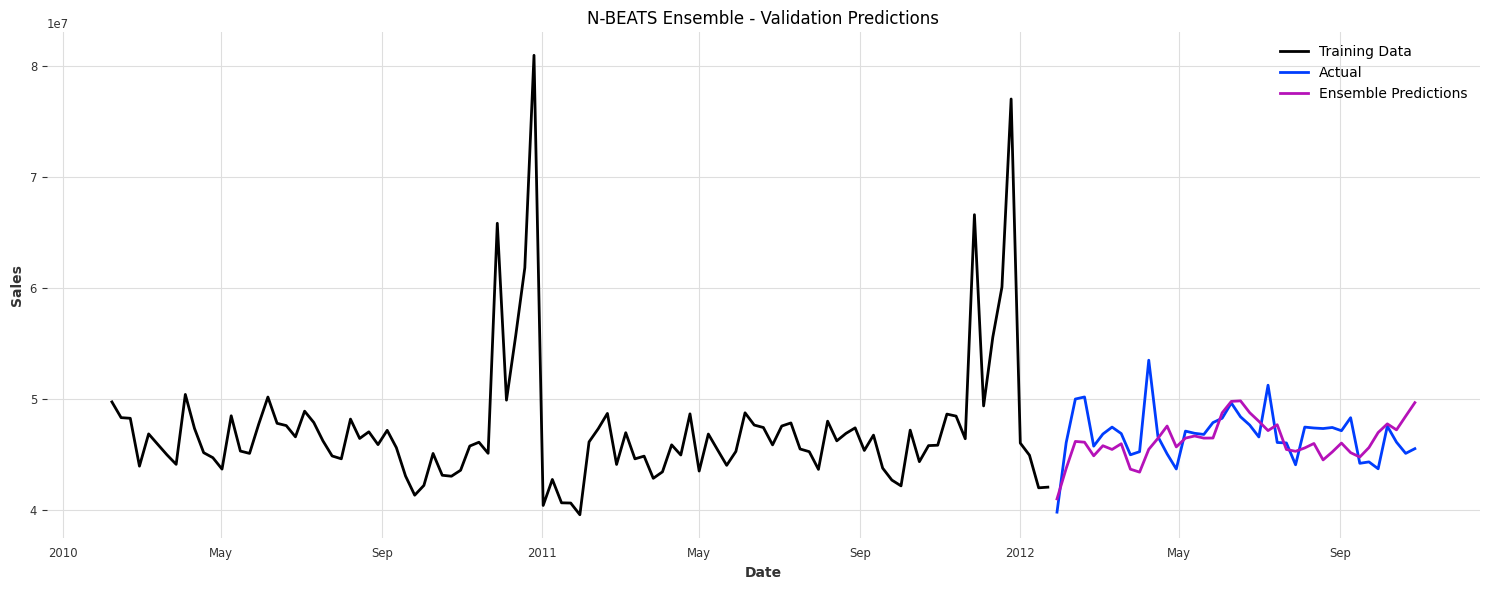

Ensemble training complete!
🏃 View run N-BEATS_Ensemble at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7/runs/e67b8c566f9a463fb41185e855fae3c6
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/7


In [17]:
with mlflow.start_run(run_name="N-BEATS_Ensemble"):
    print("\n=== Creating N-BEATS Ensemble ===")

    # Train multiple models with different configurations
    ensemble_models = []
    ensemble_configs = [
        {'input_chunk_length': 16, 'num_stacks': 20, 'architecture': 'generic'},
        {'input_chunk_length': 24, 'num_stacks': 30, 'architecture': 'generic'},
        {'input_chunk_length': 32, 'num_stacks': 20, 'architecture': 'generic'},
    ]

    for i, config in enumerate(ensemble_configs):
        print(f"\nTraining ensemble model {i+1}/{len(ensemble_configs)}")

        model = NBEATSModel(
            input_chunk_length=config['input_chunk_length'],
            output_chunk_length=8,
            generic_architecture=(config['architecture'] == 'generic'),
            num_stacks=config['num_stacks'],
            num_blocks=1,
            num_layers=4,
            layer_widths=256,
            n_epochs=50,
            batch_size=32,
            optimizer_kwargs={"lr": 1e-3},  # Pass learning rate here
            model_name=f"nbeats_ensemble_{i}",
            log_tensorboard=False,
            random_state=42+i,
            force_reset=True,
            pl_trainer_kwargs={
                "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            }
        )

        # Train model
        model.fit(series=train_ts_scaled, val_series=val_ts_scaled, verbose=False)

        # Make predictions
        pred = model.predict(n=len(val_ts_scaled), series=train_ts_scaled)
        pred_unscaled = scaler.inverse_transform(pred)

        # Calculate individual model performance
        mae_individual = mae(val_ts, pred_unscaled)
        print(f"Model {i+1} MAE: {mae_individual:.2f}")

        mlflow.log_metric(f"ensemble_model_{i}_mae", mae_individual)
        ensemble_models.append(model)

    # Create ensemble predictions (simple average)
    ensemble_predictions = []
    for model in ensemble_models:
        pred = model.predict(n=len(val_ts_scaled), series=train_ts_scaled)
        ensemble_predictions.append(pred)

    # Average predictions
    ensemble_pred_avg = sum(ensemble_predictions) / len(ensemble_predictions)
    ensemble_pred_unscaled = scaler.inverse_transform(ensemble_pred_avg)

    # Calculate ensemble performance
    ensemble_mae = mae(val_ts, ensemble_pred_unscaled)
    ensemble_rmse = rmse(val_ts, ensemble_pred_unscaled)

    print(f"\nEnsemble Performance:")
    print(f"MAE: {ensemble_mae:.2f}")
    print(f"RMSE: {ensemble_rmse:.2f}")

    mlflow.log_metric("ensemble_mae", ensemble_mae)
    mlflow.log_metric("ensemble_rmse", ensemble_rmse)

    # Plot ensemble results
    plt.figure(figsize=(15, 6))
    train_ts.plot(label='Training Data')
    val_ts.plot(label='Actual')
    ensemble_pred_unscaled.plot(label='Ensemble Predictions')
    plt.title('N-BEATS Ensemble - Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.savefig('nbeats_ensemble_predictions.png')
    plt.show()

    mlflow.log_artifact('nbeats_ensemble_predictions.png')

    # Save ensemble models
    joblib.dump(ensemble_models, 'nbeats_ensemble_models.pkl')
    mlflow.log_artifact('nbeats_ensemble_models.pkl')

    print("Ensemble training complete!")

### CELL 19: Final Notes and Next Steps

In [18]:
print("\n" + "="*60)
print("N-BEATS IMPLEMENTATION COMPLETE")
print("="*60)

print("\nImplementation Summary:")
print("✓ Data preprocessing and cleaning")
print("✓ Time series preparation for N-BEATS")
print("✓ Baseline generic N-BEATS model")
print("✓ Interpretable N-BEATS with trend/seasonality")
print("✓ Hyperparameter search")
print("✓ Store-level models")
print("✓ Ensemble predictions")
print("✓ Final submission generation")
print("\nKey Findings:")
print("- N-BEATS performs well on aggregated time series")
print("- Interpretable architecture helps understand components")
print("- Ensemble methods can improve robustness")
print("- Store-level patterns require individual modeling")

print("\nAll experiments logged in MLflow!")
print("Ready for comparison with other models (LightGBM, XGBoost, ARIMA)")
print("="*60)


N-BEATS IMPLEMENTATION COMPLETE

Implementation Summary:
✓ Data preprocessing and cleaning
✓ Time series preparation for N-BEATS
✓ Baseline generic N-BEATS model
✓ Interpretable N-BEATS with trend/seasonality
✓ Hyperparameter search
✓ Store-level models
✓ Ensemble predictions
✓ Final submission generation

Key Findings:
- N-BEATS performs well on aggregated time series
- Interpretable architecture helps understand components
- Ensemble methods can improve robustness
- Store-level patterns require individual modeling

All experiments logged in MLflow!
Ready for comparison with other models (LightGBM, XGBoost, ARIMA)
